In [1]:
import warnings
from typing import Optional, Sequence
import numpy as np
import os
import pandas as pd
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchmetrics.functional import pairwise_cosine_similarity
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

import lightly
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss

from avalanche.training.plugins import SupervisedPlugin
from avalanche.training.templates.supervised import SupervisedTemplate
from avalanche.training.plugins.evaluation import default_evaluator
from avalanche.models.dynamic_modules import MultiTaskModule
from avalanche.models import FeatureExtractorBackbone
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    loss_metrics,
    forgetting_metrics,
    confusion_matrix_metrics
)
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

from datasets.coil100 import Coil100Dataset
from self_supervision.ssl import BarlowTwins
from clp.clp import CLP


In [3]:
# # Copyright (c) 2021 ContinualAI.                                              #
# Copyrights licensed under the MIT License.                                   #
# See the accompanying LICENSE file for terms.                                 #
#                                                                              #
# Date: 06-04-2021                                                             #
# Author(s): Tyler Hayes                                                       #
# E-mail: contact@continualai.org                                              #
# Website: avalanche.continualai.org                                           #
################################################################################

"""
This is a simple example on how to use the Deep SLDA strategy.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import torch
import warnings
from torchvision import transforms

from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    loss_metrics,
    forgetting_metrics,
)
from avalanche.logging import InteractiveLogger
from avalanche.benchmarks.classic import CORe50
from avalanche.training.supervised.deep_slda import StreamingLDA
from avalanche.models import SLDAResNetModel

n_classes = 100
batch_size = 512
shrinkage = 1e-4
plastic_cov = True

# Device config
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device ", device)

root_dir = '/home/ehajizad/ss_learning/neuromorphic-continual-learning'
dataset_dir = '/home/ehajizad/ss_learning/ssl_tests/datasets/coil-100'

test_size = 0.9
train_size = 1 - test_size

train_ds = Coil100Dataset(root_dir=dataset_dir, obj_list = np.arange(n_classes),
                          transform=transforms.ToTensor(), size=64,
                          train=True, test_size=test_size)
test_ds = Coil100Dataset(root_dir=dataset_dir,obj_list = np.arange(n_classes),
                         transform=transforms.ToTensor(), size=64,
                         train=False, test_size=test_size)


# Load pretrained model
resnet = lightly.models.ResNetGenerator('resnet-9')
model = nn.Sequential(*list(resnet.children())[:-1],
                         nn.AdaptiveAvgPool2d(2))

model = model.to(device)
model.load_state_dict(torch.load(
        root_dir+"/models/coil100_simsiam_resnet9.pth",
        map_location=device))

# model = model.backbone[0:-1]
model = nn.Sequential(*list(model), nn.Flatten())
model.eval()

feature_size = 2048
# feature_size = 32768


# ---------

# --- TRANSFORMATIONS
# _mu = [0.485, 0.456, 0.406]  # imagenet normalization
# _std = [0.229, 0.224, 0.225]
# transform = transforms.Compose(
#     [
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=_mu, std=_std),
#     ]
# )
# ---------

# --- BENCHMARK CREATION
benchmark = nc_benchmark(train_ds, test_ds, n_experiences=n_classes, 
                         shuffle=False,task_labels=False)
# ---------

log_dir = "logs/coil_100_clean/" + "slda_test_size=0.9" # + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 

eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=benchmark.n_classes, save_image=False, stream=True),
    loggers=[TensorboardLogger(log_dir)],
)

criterion = torch.nn.CrossEntropyLoss()
# model = SLDAResNetModel(
#     device=device,
#     arch="resnet18",
#     imagenet_pretrained=model,
# )

# CREATE THE STRATEGY INSTANCE
cl_strategy = StreamingLDA(
    model,
    criterion,
    feature_size,
    n_classes,
    eval_mb_size=batch_size,
    train_mb_size=batch_size,
    train_epochs=1,
    shrinkage_param=shrinkage,
    streaming_update_sigma=plastic_cov,
    device=device,
    evaluator=eval_plugin,
)

warnings.warn(
    "The Deep SLDA example is not perfectly aligned with "
    "the paper implementation since it does not use a base "
    "initialization phase and instead starts streming from "
    "pre-trained weights."
)


# TRAINING LOOP
n_loops = 1
print("Starting experiment...")
for loop in range(1,n_loops+1):
    for i, exp in enumerate(benchmark.train_stream):

        # fit SLDA model to batch (one sample at a time)
        cl_strategy.train(exp)

        # evaluate model on test data
        results = cl_strategy.eval(benchmark.test_stream[:min(loop*(i+1),n_classes)])

device  cuda


100%|██████████| 7200/7200 [00:00<00:00, 1167516.77it/s]
/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/avalanche/training/plugins/evaluation.py:81: UserWarning: No benchmark provided to the evaluation plugin. Metrics may be computed on inconsistent portion of streams, use at your own risk.
  warnings.warn(
/tmp/ipykernel_2761908/2764219561.py:126: UserWarning: The Deep SLDA example is not perfectly aligned with the paper implementation since it does not use a base initialization phase and instead starts streming from pre-trained weights.
  warnings.warn(
/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/avalanche/training/plugins/evaluation.py:228: UserWarning: Evaluation stream is not equal to the complete test stream. This may result in inconsistent metrics. Use at your own risk.
  warnings.warn(msgw)


Starting experiment...


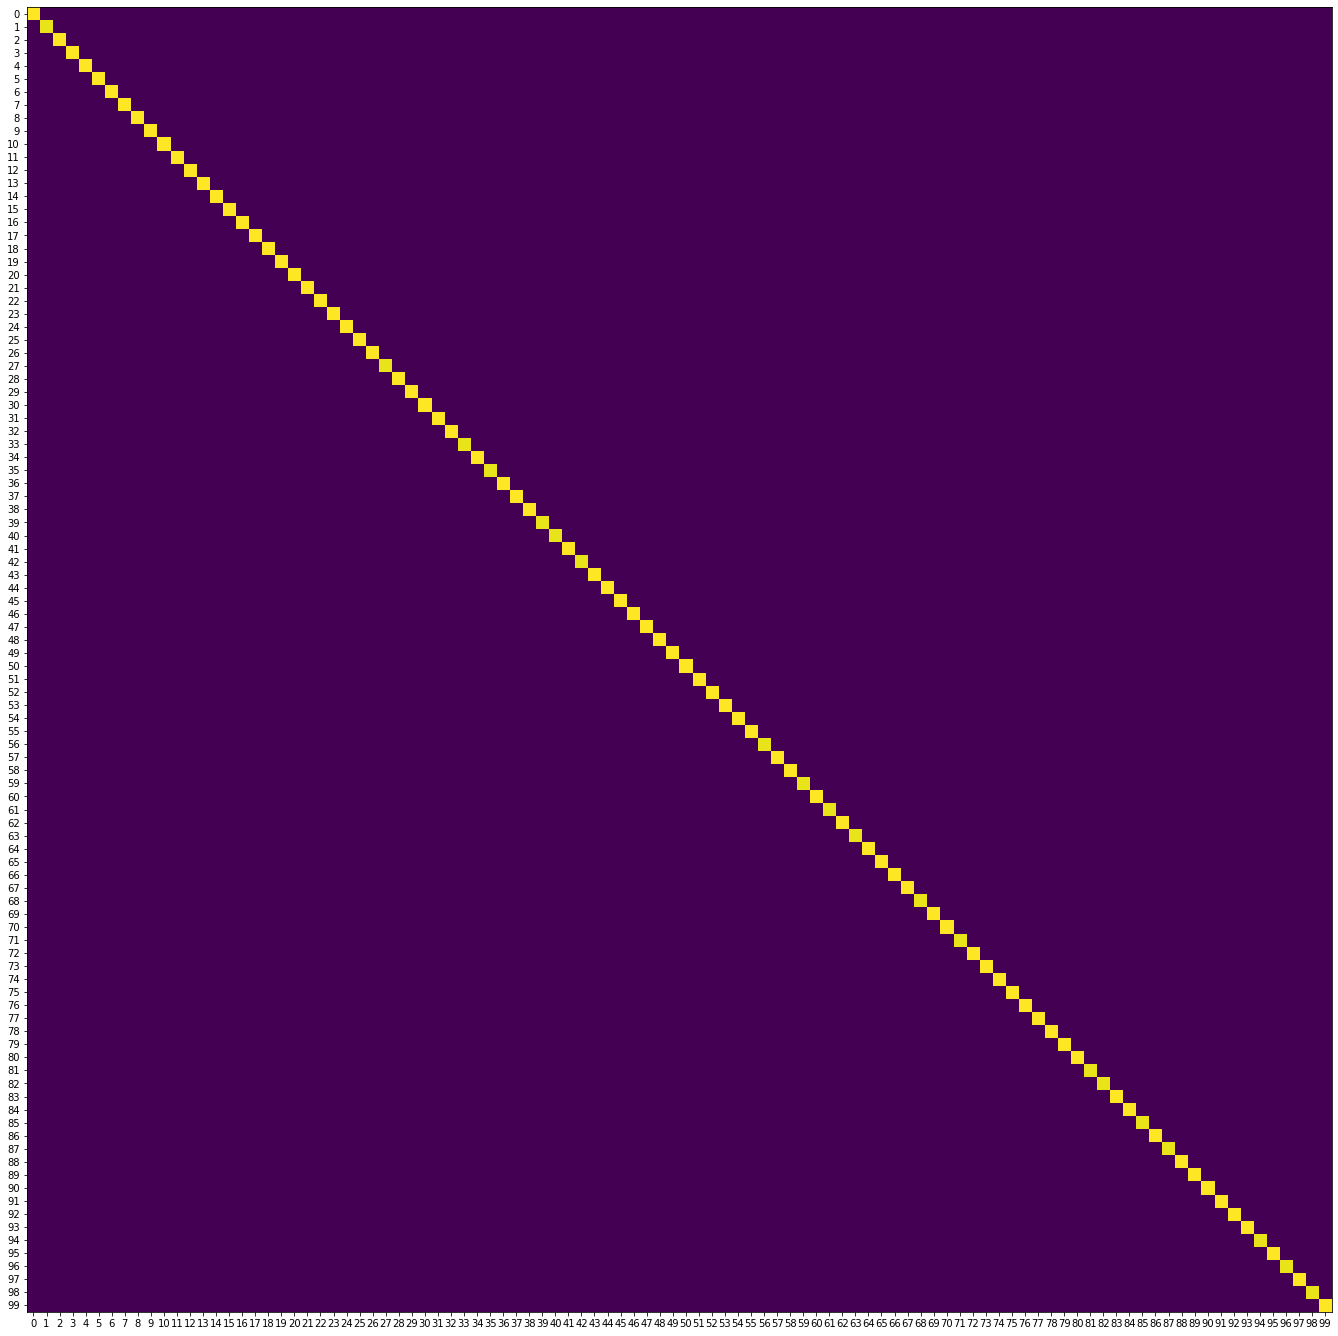

In [4]:
plt.figure(figsize=(24,24))
cm = results["ConfusionMatrix_Stream/eval_phase/test_stream"]
plt.imshow(cm)
plt.xticks(np.arange(100))
plt.yticks(np.arange(100))
# plt.grid()
plt.show()

In [13]:
with open('slda.pkl', 'wb') as f:
    pickle.dump(results, f)
        
# with open('clp_cosine.pkl', 'rb') as f:
#     results = pickle.load(f)

In [14]:
plt.figure(figsize=(16,16))
cm = results["ConfusionMatrix_Stream/eval_phase/test_stream"]
plt.imshow(cm)


KeyError: 'ConfusionMatrix_Stream/eval_phase/test_stream'

<Figure size 1152x1152 with 0 Axes>

In [5]:
for i, exp in enumerate(benchmark.train_stream):
    print(exp.classes_in_this_experience)

[2]
[0]
[8]
[1]
[3]
[7]
[4]
[9]
[5]
[6]


In [7]:
%reload_ext tensorboard

In [8]:
%tensorboard --logdir 'logs/clp100/' --port 6009

Reusing TensorBoard on port 6009 (pid 2053948), started 9:24:53 ago. (Use '!kill 2053948' to kill it.)